In [176]:
### Library
import numpy as np  
import pandas as pd

import timeit
import time
import os
from datetime import datetime
from pathlib import Path
import ipynbname
import itertools

import json
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'> Using device: {device}')

> Using device: cuda:0


In [177]:
### Design model
torch.manual_seed(42)  # Set random seed for reproducibility

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(6, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 1)
        self.relu3 = nn.ReLU()

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        # x = self.fc3(x)
        return x

In [178]:
### Make result directory
script_dir = os.path.abspath('')
current_file = os.path.basename(globals()['__vsc_ipynb_file__']).replace('.ipynb', '')
dt_string = datetime.now().strftime("%y%m%d_%H%M%S")
result_dir = os.path.join(script_dir, 'Results', current_file, dt_string)
Path(result_dir).mkdir(parents=True, exist_ok=True)

In [179]:
### Get climate change scenarios data
data_df = pd.read_csv('./Data/Yearly_Temp_Full_SCP.csv', index_col=0, header=0, 
                      names=['Year', 'History', 'History low', 'History high',
                             'SSP1-1.9', 'SSP1-1.9 low', 'SSP1-1.9 high',
                             'SSP1-2.6', 'SSP1-2.6 low', 'SSP1-2.6 high',
                             'SSP2-4.5', 'SSP2-4.5 low', 'SSP2-4.5 high',
                             'SSP3-7.0', 'SSP3-7.0 low', 'SSP3-7.0 high',
                             'SSP5-8.5', 'SSP5-8.5 low', 'SSP5-8.5 high'])
data_df.head()

year_2025_month_temp = {'SSP1-1.9': [27.13, 28.08, 29.40, 30.37, 30.12, 29.14, 28.57, 28.59, 28.46, 28.24, 27.77, 27.14],
                        'SSP1-2.6': [27.25, 28.20, 29.48, 30.42, 30.27, 29.26, 28.61, 28.62, 28.51, 28.32, 27.83, 27.17],
                        'SSP2-4.5': [27.25, 28.18, 29.53, 30.50, 30.14, 29.18, 28.63, 28.66, 28.56, 28.26, 27.88, 27.27],
                        'SSP3-7.0': [27.15, 28.10, 29.39, 30.38, 30.16, 29.20, 28.60, 28.63, 28.51, 28.30, 27.75, 27.15],
                        'SSP5-8.5': [27.26, 28.18, 29.53, 30.49, 30.27, 29.28, 28.73, 28.75, 28.62, 28.37, 27.93, 27.31]}

year_2025_year_temp = {'SSP1-1.9': data_df.loc[2025, 'SSP1-1.9'],
                       'SSP1-2.6': data_df.loc[2025, 'SSP1-2.6'],
                       'SSP2-4.5': data_df.loc[2025, 'SSP2-4.5'],
                       'SSP3-7.0': data_df.loc[2025, 'SSP3-7.0'],
                       'SSP5-8.5': data_df.loc[2025, 'SSP5-8.5']}

year_2025_avg_month_temp = np.mean([val for _, val in enumerate(year_2025_month_temp.values())], axis=0)

year_2025_avg_year_temp = np.mean([val for _, val in enumerate(year_2025_year_temp.values())], axis=0)

Recalcuate_year_2025_avg_month_temp = year_2025_avg_month_temp - np.mean(year_2025_avg_month_temp) + year_2025_avg_year_temp
Recalcuate_year_2025_avg_year_temp = np.mean(Recalcuate_year_2025_avg_month_temp)

data_to_save = {
    'Recalcuate_year_2025_avg_month_temp': Recalcuate_year_2025_avg_month_temp.tolist(),
    'Recalcuate_year_2025_avg_year_temp': Recalcuate_year_2025_avg_year_temp,
}

# with open(os.path.join(result_dir, 'Recalcuate_year_2025_temp.json'), 'w') as f:
#     json.dump(data_to_save, f)

print(f'> Average predicted year 2025 monthly temperature: {np.round(Recalcuate_year_2025_avg_month_temp,1)}')
print(f'> Average predicted year 2025 yearly temperature: {Recalcuate_year_2025_avg_year_temp:.2f}')


> Average predicted year 2025 monthly temperature: [27.1 28.1 29.4 30.3 30.1 29.1 28.5 28.6 28.4 28.2 27.7 27.1]
> Average predicted year 2025 yearly temperature: 28.55


In [180]:
### Preprocessing climate data into mean and std
z_10, z_90 = stats.norm.ppf(0.10), stats.norm.ppf(0.90)
data_history = {'Year': []}
data_future = {'Year': []}

for index, row in data_df.iterrows():
    if index <= 2014:
        data_history['Year'].append(index)
        
        col = 'History'
        per_10, per_90 = row[col + ' low'], row[col + ' high']
        std = (per_90 - per_10) / (z_90 - z_10)
        if index == data_df.index[0]:
            data_history[col + ' mean'] = []
            data_history[col + ' std'] = []
        data_history[col + ' mean'].append(row[col])
        data_history[col + ' std'].append(std)
    else:
        data_future['Year'].append(index)
        
        for col in data_df.columns[::3]:
            if col == 'History':
                continue
            per_10, per_90 = row[col + ' low'], row[col + ' high']
            std = (per_90 - per_10) / (z_90 - z_10)
            if index == 2015:
                data_future[col + ' mean'] = []
                data_future[col + ' std'] = []
            data_future[col + ' mean'].append(row[col])
            data_future[col + ' std'].append(std)

data_history_df = pd.DataFrame(data_history) 
data_history_df.set_index(data_history_df.columns[0], inplace=True)
# data_history_df.to_csv(os.path.join(result_dir, 'data_history.csv'))
data_history_df.head()

data_future_df = pd.DataFrame(data_future)
data_future_df.set_index(data_future_df.columns[0], inplace=True)
# data_future_df.to_csv(os.path.join(result_dir, 'data_future.csv'))
data_future_df.head()

SSP1-1.9 mean  SSP1-1.9 std  SSP1-2.6 mean  SSP1-2.6 std  SSP2-4.5 mean  \
Year                                                                            
2015          28.26      0.339432          28.19      0.335531          28.33   
2016          28.28      0.335531          28.20      0.319925          28.31   
2017          28.26      0.331629          28.32      0.409660          28.30   
2018          28.32      0.316023          28.31      0.284811          28.30   
2019          28.38      0.358940          28.44      0.335531          28.32   

      SSP2-4.5 std  SSP3-7.0 mean  SSP3-7.0 std  SSP5-8.5 mean  SSP5-8.5 std  
Year                                                                          
2015      0.390152          28.31      0.288713          28.25      0.366743  
2016      0.343334          28.27      0.366743          28.38      0.351137  
2017      0.284811          28.21      0.296516          28.24      0.386251  
2018      0.366743          28.34      0.335531          28.39      0.292614  
2019      0.335531          28.46      0.468182          28.37      0.335531

In [181]:
### Climate data sampling
z_10, z_90 = stats.norm.ppf(0.10), stats.norm.ppf(0.90)
climate_data_sample = {col.replace(' mean', ''):{'Year':[]} for col in data_future_df.columns[::2].tolist()}
climate_data_sample_df = climate_data_sample.copy()
n_samples = 200
for col in climate_data_sample.keys():
    for i_sample in range(n_samples):
        difference_max = 0
        difference_mu_max = 0
        for index, row in data_future_df.iterrows():
            if index < 2025:
                continue
            elif index == 2025:
                climate_data_sample[col]['Year'].append(index) if i_sample == 0 else None
                climate_data_sample[col]['sample_'+str(i_sample)] = [Recalcuate_year_2025_avg_year_temp]
                # data_sample[col]['sample_'+str(i_sample)] = [data_future_df.loc[index, col + ' mean']]
                continue
    
            mu_0 = data_future_df.loc[index-1, col + ' mean']
            sigma_0 = data_future_df.loc[index-1, col + ' std']
            mu_1 = data_future_df.loc[index, col + ' mean']
            sigma_1 = data_future_df.loc[index, col + ' std']
            
            rho = 0.99
            mu_1_given_0 = mu_1 + rho * (sigma_1 / sigma_0) * (climate_data_sample[col]['sample_'+str(i_sample)][-1] - mu_0)
            sigma_1_given_0 = np.sqrt((1 - rho**2)) * sigma_1
            sample = float(np.random.normal(mu_1_given_0, sigma_1_given_0, 1)[0])
                
            climate_data_sample[col]['Year'].append(index) if i_sample == 0 else None
            climate_data_sample[col]['sample_'+str(i_sample)].append(sample)
    climate_data_sample_df[col] = pd.DataFrame(climate_data_sample[col])
    climate_data_sample_df[col].set_index(climate_data_sample_df[col].columns[0], inplace=True)
    climate_data_sample_df[col] = climate_data_sample_df[col].T
    # climate_data_sample_df[col].to_csv(os.path.join(result_dir, 'climate_data_sampling_' + col + '.csv'))
    
climate_data_sample_df[list(climate_data_sample_df.keys())[0]].head()


Year        2025       2026       2027       2028       2029       2030  \
sample_0  28.554  28.556463  28.669006  28.657903  28.700982  28.751283   
sample_1  28.554  28.575864  28.665457  28.749221  28.782670  28.688494   
sample_2  28.554  28.603761  28.585307  28.685658  28.624708  28.587507   
sample_3  28.554  28.619409  28.578415  28.570067  28.470980  28.483233   
sample_4  28.554  28.571360  28.600692  28.641597  28.688923  28.680934   

Year           2031       2032       2033       2034  ...       2091  \
sample_0  28.808440  28.801180  28.708643  28.752532  ...  28.491931   
sample_1  28.691958  28.723622  28.662761  28.654079  ...  29.035918   
sample_2  28.658900  28.719238  28.767560  28.825538  ...  28.426441   
sample_3  28.367459  28.398154  28.416931  28.537407  ...  29.161448   
sample_4  28.703650  28.729817  28.704327  28.768375  ...  28.318337   

Year           2092       2093       2094       2095       2096       2097  \
sample_0  28.529488  28.542148  28.656047  28.555265  28.514694  28.582100   
sample_1  28.950322  28.978678  29.100730  29.025994  28.940325  28.988603   
sample_2  28.395546  28.439425  28.521289  28.528476  28.508233  28.554688   
sample_3  29.122689  29.149804  29.241896  29.111605  28.966703  28.989527   
sample_4  28.361123  28.296589  28.310696  28.249354  28.175688  28.265993   

Year           2098       2099       2100  
sample_0  28.512199  28.561618  28.654275  
sample_1  28.995570  29.053144  29.047833  
sample_2  28.590270  28.586157  28.742287  
sample_3  28.958757  28.999004  28.916597  
sample_4  28.307593  28.318507  28.400379  

[5 rows x 76 columns]

In [182]:
### Load sampled data
load_path = os.path.join(script_dir, 'Results', current_file, '250129_172531')
climate_data_sample_df = {col.replace(' mean', ''):[] for col in data_future_df.columns[::2].tolist()}
for col in climate_data_sample_df.keys():
    climate_data_sample_df[col] = pd.read_csv(os.path.join(load_path, 'climate_data_sampling_' + col + '.csv'), index_col=0, header=0)
    climate_data_sample_df[col].columns = climate_data_sample_df[col].columns.astype(int)

climate_data_sample = {col.replace(' mean', ''):{'Year':[]} for col in data_future_df.columns[::2].tolist()}    
for col in climate_data_sample.keys():
    climate_data_sample[col]['Year'] = climate_data_sample_df[col].columns.astype(int).tolist()
    for i, row in climate_data_sample_df[col].iterrows():
        climate_data_sample[col][i] = row.values.tolist()


In [183]:
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerBase
from matplotlib.lines import Line2D

class MultiLineHandler(HandlerBase):
    def __init__(self, colors, line_spacing=2.5, **kw):
        super().__init__(**kw)
        self.colors = colors
        self.line_spacing = line_spacing

    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        lines = []
        n = len(self.colors)
        total_height = n + (n - 1) * self.line_spacing
        step = height / total_height
        for i, color in enumerate(self.colors):
            y = ydescent + step * (i * (1 + self.line_spacing) + 0.5)
            line = Line2D([xdescent, xdescent + width], [y, y],
                          color=color, linewidth=orig_handle.get_linewidth())
            line.set_transform(trans)
            lines.append(line)
        return lines
    

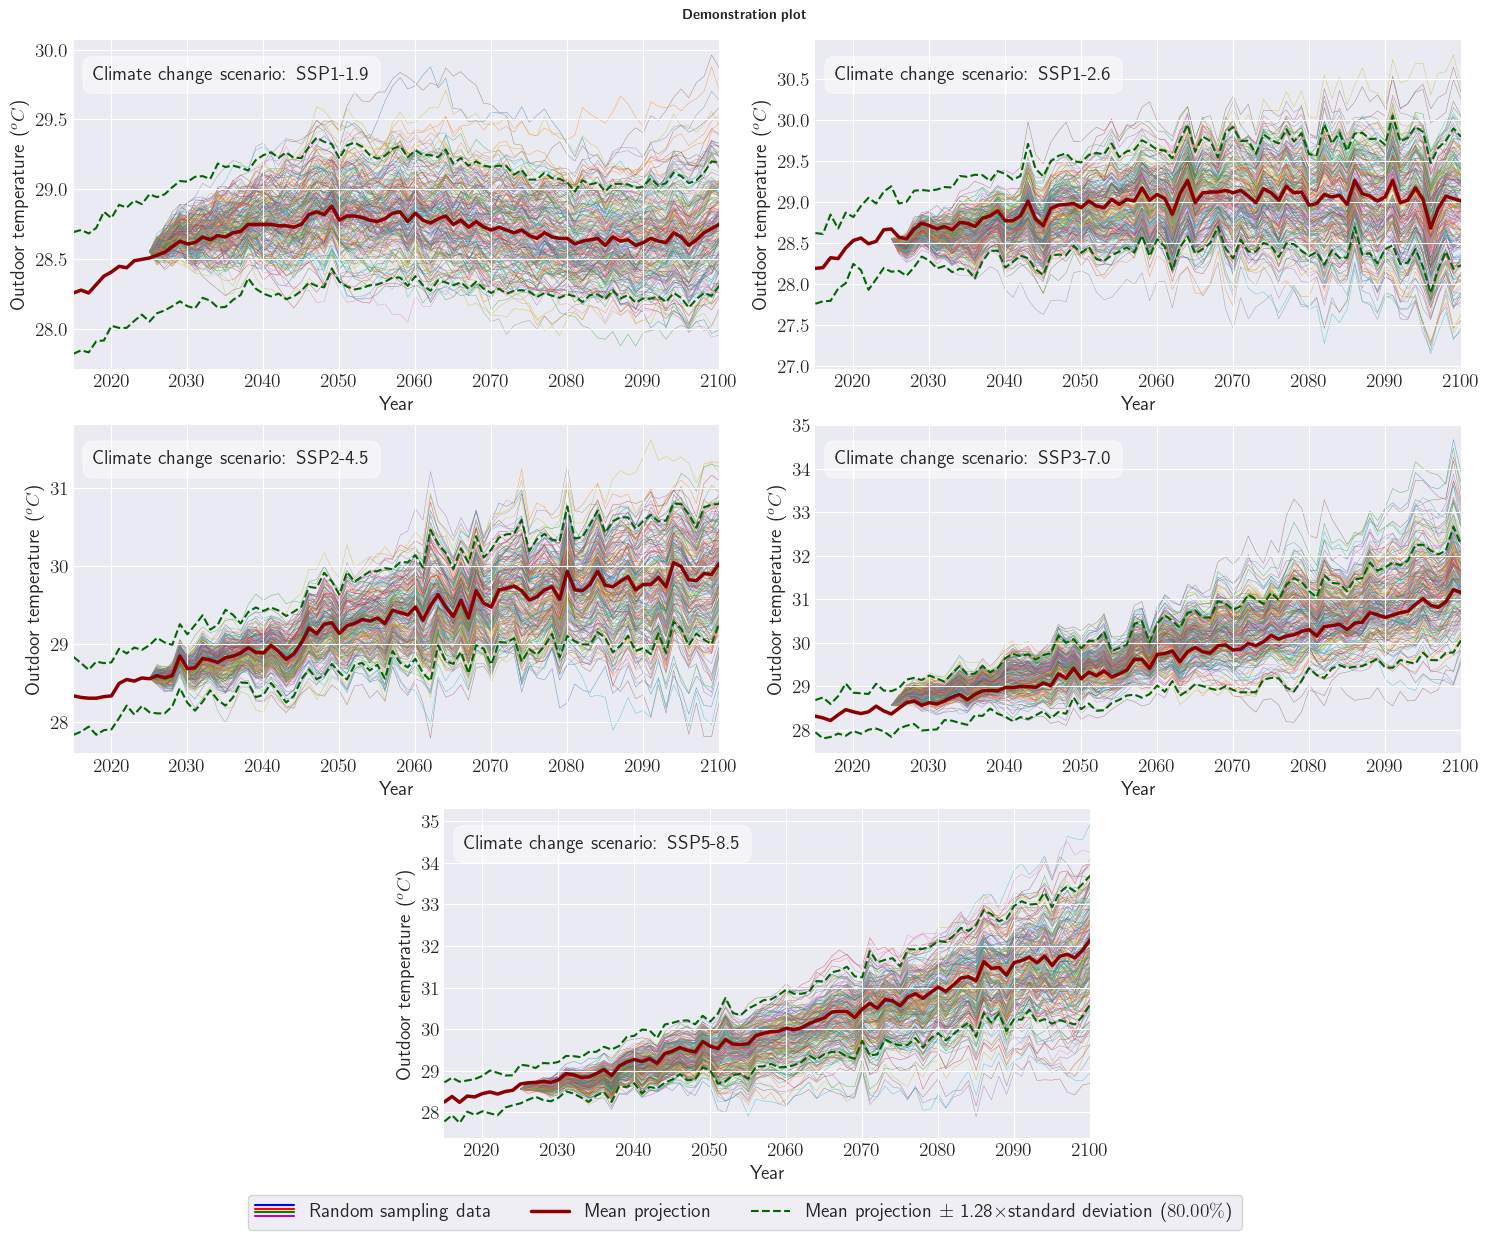

In [184]:
### Plot climate data sampling (Outdoor temperature)
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['text.usetex'] = True
[nrows, ncols] = [2, 2]
fig = plt.figure(figsize=(15, 12))
fig.suptitle(r'\textbf{Demonstration plot}', y=0.99, fontsize=10)

gs = gridspec.GridSpec(nrows+1, ncols*2, figure=fig)
axes = [fig.add_subplot(gs[i, 2*j:2*j+2]) for i in range(nrows) for j in range(ncols)]
axes.append(fig.add_subplot(gs[2, 1:3]))
    
for i in range(len(list(climate_data_sample.keys()))):
    col = list(climate_data_sample.keys())[i]
    ax1 = axes[i]
    for j in range(climate_data_sample_df[col].shape[0]):
        ax1.plot(climate_data_sample_df[col].loc['sample_'+str(j)], alpha=0.8, linewidth=0.3, zorder=-1)
    ax1.plot([], [], color='gray', alpha=0.8, label='Random sampling data', zorder=-1)
        
    ax1.plot(data_future_df[col + ' mean'], label="Mean projection", color='darkred', linestyle='-', linewidth=2.5)

    z_low, z_high = stats.norm.ppf(0.5 - 0.9000 / 2), stats.norm.ppf(0.5 + 0.9000 / 2)
    ax1.plot(data_future_df[col + ' mean'] + z_10*data_future_df[col + ' std'], label=r"Mean projection $\pm$ 1.28$\times$standard deviation ($80.00\%$)", color='darkgreen', linestyle='--')
    ax1.plot(data_future_df[col + ' mean'] + z_90*data_future_df[col + ' std'], color='darkgreen', linestyle='--')

    ax1.set_xlabel(r'Year', fontsize=14)
    ax1.set_ylabel(r'Outdoor temperature ($^{o}C$)', fontsize=14)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.tick_params(axis='y', labelsize=14)
    ax1.set_xlim(min(data_future_df.index), max(data_future_df.index))
    ax1.text(0.03, 0.92, rf'Climate change scenario: {col}', transform=ax1.transAxes, fontsize=14,
             ha='left', va='top', bbox=dict(facecolor='white', alpha=0.5, edgecolor='white', boxstyle='round,pad=0.5'))
               
handles, labels = axes[0].get_legend_handles_labels()
proxy = Line2D([], [], color='gray', alpha=0.8, zorder=-1)
handles[0] = proxy
fig.legend(handles, labels, handler_map={proxy: MultiLineHandler(['m','g','r','b'], line_spacing=0.2)}, 
           loc='lower center', bbox_to_anchor=(0.5, -0.035), ncols=len(labels), fontsize=14, frameon=True)

plt.tight_layout(rect=(0, 0, 1, 1))
plt.subplots_adjust(hspace=0.17, wspace=0.35)
plt.savefig(os.path.join(result_dir, 'Climate_data_sampling_temp.png'), dpi=400)
plt.show()


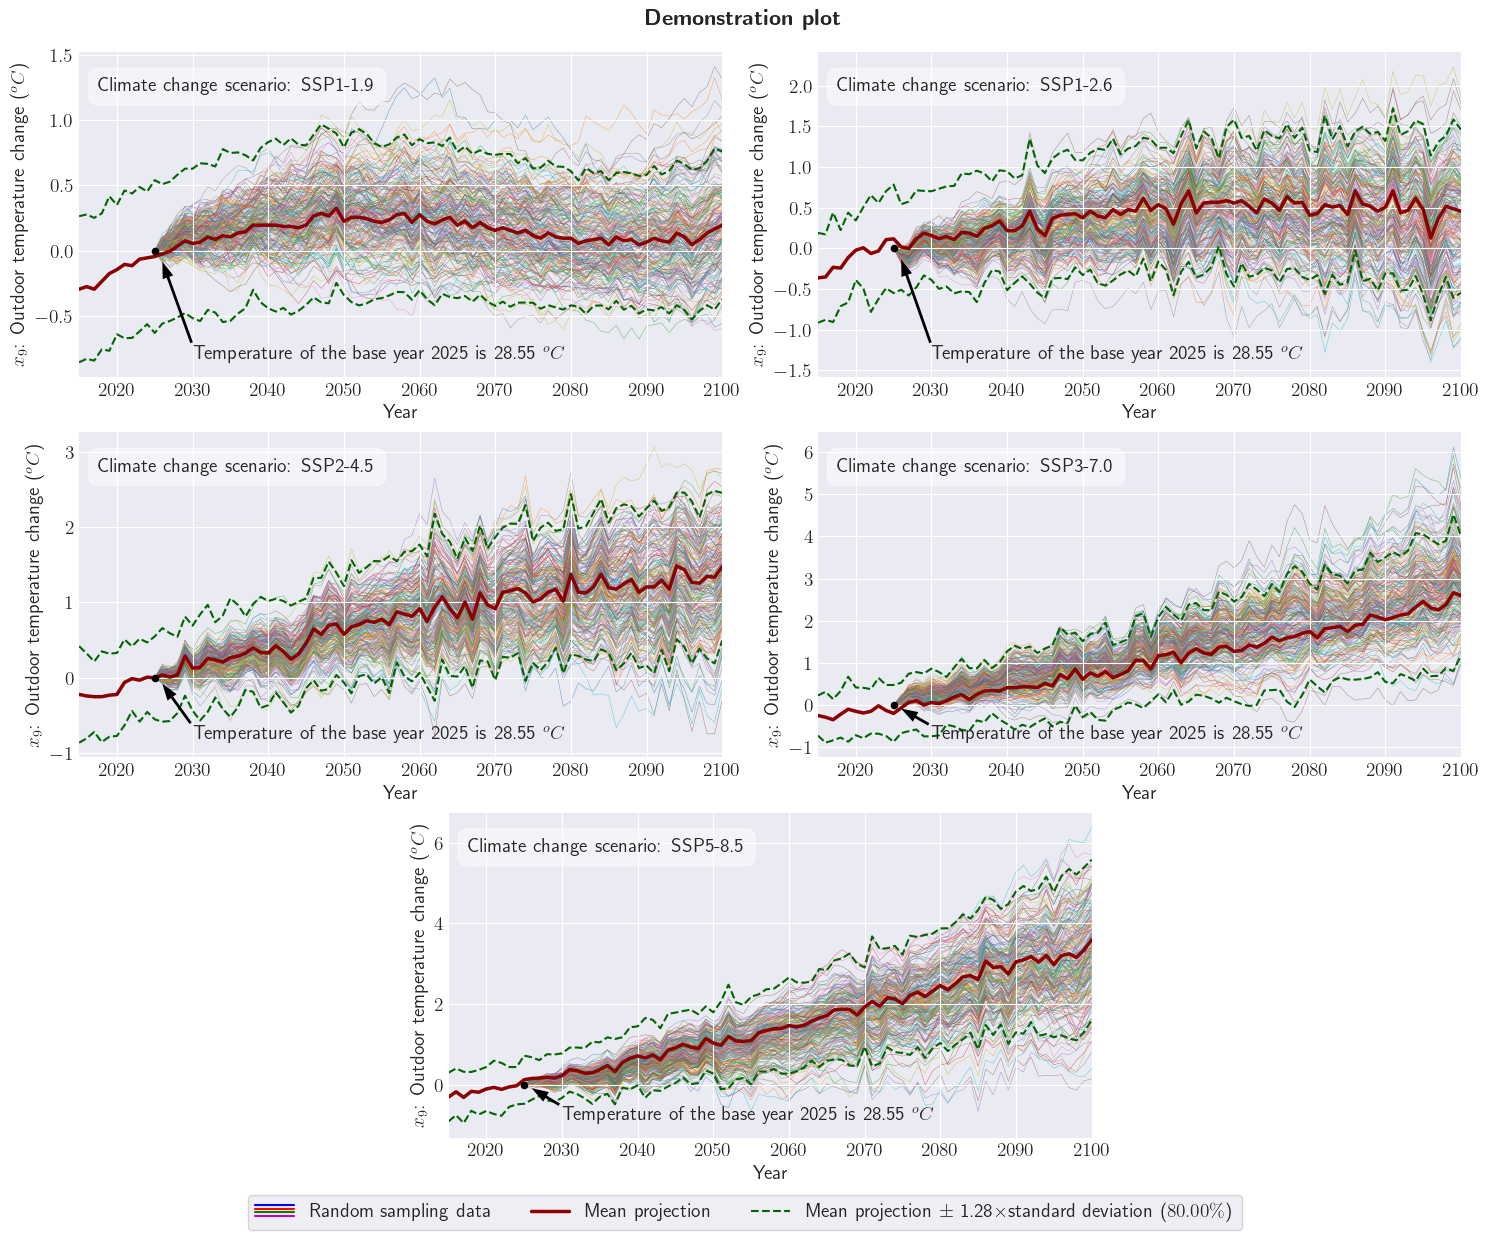

In [185]:
### Plot climate data sampling (Outdoor temperature change)
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['text.usetex'] = True
[nrows, ncols] = [2, 2]
fig = plt.figure(figsize=(15, 12))
fig.suptitle(r'\textbf{Demonstration plot}', y=0.99, fontsize=16)

gs = gridspec.GridSpec(nrows+1, ncols*2, figure=fig)
axes = [fig.add_subplot(gs[i, 2*j:2*j+2]) for i in range(nrows) for j in range(ncols)]
axes.append(fig.add_subplot(gs[2, 1:3]))

for i in range(len(list(climate_data_sample.keys()))):
    col = list(climate_data_sample.keys())[i]
    ax1 = axes[i]
    base_year_temp = climate_data_sample_df[col].iloc[0,0]
    for j in range(climate_data_sample_df[col].shape[0]):
        ax1.plot(climate_data_sample_df[col].loc['sample_'+str(j)] - base_year_temp, alpha=0.8, linewidth=0.3, zorder=-1)
    ax1.plot([], [], color='gray', alpha=0.8, label='Random sampling data', zorder=-1)
    
    ax1.plot(data_future_df[col + ' mean'] - base_year_temp, label="Mean projection", color='darkred', linestyle='-', linewidth=2.5)

    z_low, z_high = stats.norm.ppf(0.5 - 0.9000 / 2), stats.norm.ppf(0.5 + 0.9000 / 2)
    ax1.plot(data_future_df[col + ' mean'] + z_low*data_future_df[col + ' std'] - base_year_temp, label=r"Mean projection $\pm$ 1.28$\times$standard deviation ($80.00\%$)", color='darkgreen', linestyle='--')
    ax1.plot(data_future_df[col + ' mean'] + z_high*data_future_df[col + ' std'] - base_year_temp, color='darkgreen', linestyle='--')
    ax1.set_xlabel(r'Year', fontsize=14)
    ax1.set_ylabel(r'$x_{9}$: Outdoor temperature change ($^{o}C$)', fontsize=14)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.tick_params(axis='y', labelsize=14)
    ax1.set_xlim(min(data_future_df.index), max(data_future_df.index))
    ax1.get_ylim()
    ax1.text(0.03, 0.92, rf'Climate change scenario: {col}', transform=ax1.transAxes, fontsize=14,
             ha='left', va='top', bbox=dict(facecolor='white', alpha=0.5, edgecolor='white', boxstyle='round,pad=0.5'))
    ax1.scatter(2025, 0, color='k', marker='o', s=20, zorder=10)
    ax1.annotate(rf'Temperature of the base year 2025 is {base_year_temp:.2f}' + ' $^{o}C$',
                 xytext=(2030, ax1.get_ylim()[0] + (ax1.get_ylim()[1]-ax1.get_ylim()[0])/18),
                 xy=(2025 + 1, -(0 - (ax1.get_ylim()[0] + (ax1.get_ylim()[1]-ax1.get_ylim()[0])/18))/10),
                 arrowprops=dict(facecolor='k', edgecolor='none', width=2, headwidth=8), fontsize=14)
    
handles, labels = axes[0].get_legend_handles_labels()
proxy = Line2D([], [], color='gray', alpha=0.8, zorder=-1)
handles[0] = proxy
fig.legend(handles, labels, handler_map={proxy: MultiLineHandler(['m','g','r','b'], line_spacing=0.2)}, 
           loc='lower center', bbox_to_anchor=(0.5, -0.035), ncols=len(labels), fontsize=14, frameon=True)

plt.tight_layout(rect=(0, 0, 1, 1))
plt.subplots_adjust(hspace=0.17, wspace=0.35)
plt.savefig(os.path.join(result_dir, 'Climate_data_sampling_temp_change.png'), dpi=400)
plt.show()


In [ ]:
### Get design sampling data
input_variables = ["$x_{1}$", "$x_{2}$", "$x_{3}$", "$x_{4}$", "$x_{5}$", "$x_{6}$", "$x_{7}$", "$x_{8}$", "$x_{9}$"]
output_variables = ["$y_{1}$", "$y_{2}$", "$y_{3}$", "$y_{4}$", "$y_{5}$", "$y_{6}$", "$y_{7}$", "$y_{8}$", "$y_{9}$", "$y_{10}$", "$y_{11}$"]
data_df = pd.read_excel('./Data/dataset_simulation_building.xlsx', names=input_variables + output_variables)
data_input_df = data_df[[input_variables[i] for i in [0, 1, 2, 4, 7, 8]]]

design_variables = [input_variables[i] for i in [0, 1, 2, 4, 7]]
design_data_sample_df = data_df[[input_variables[i] for i in [0, 1, 2, 4, 7]]]

design_data_sample_df.index = [f'design_{i}' for i in range(len(design_data_sample_df))]
design_data_sample_df.head()


$x_{1}$  $x_{2}$  $x_{3}$  $x_{5}$  $x_{8}$
design_0      380      240      0.2      2.2     27.0
design_1      340      240      0.4      1.0     22.5
design_2      280      220      1.2      1.8     22.0
design_3      220      240      1.0      0.6     23.0
design_4      360      260      0.4      0.2     23.0

In [188]:
### Full data sampling
load_path = os.path.join(script_dir, 'Results', 'NN_Model', '250129_170841', '172126')
model = torch.load(os.path.join(load_path, 'Full_model.pt'), map_location=device, weights_only=False)
model.load_state_dict((torch.load(os.path.join(load_path, 'Best_model.pt'), weights_only=True)))
model.eval()

scale = MinMaxScaler(feature_range=(0, 1)).fit(data_input_df.values)

data_sample = {"idx": []}
data_sample.update({var: [] for var in design_variables})
data_sample["$z$"] = []
data_sample.update({"$y^{"+str(var)+"}$" : [] for var in climate_data_sample_df[list(climate_data_sample_df.keys())[0]].columns[1:]})

for col in climate_data_sample.keys():
    for i in range(design_data_sample_df.shape[0]):        
        design_row = design_data_sample_df.iloc[i, :].values
        climate_case_data_df = climate_data_sample_df[col].iloc[:, 1:]
        
        sampled_data = np.tile(design_row, (climate_case_data_df.size, 1))
        sampled_data = np.hstack((sampled_data, climate_case_data_df.to_numpy().flatten().reshape(-1,1) - climate_data_sample_df[col].iloc[0, 0]))
        
        sampled_data_df = pd.DataFrame(sampled_data, columns=design_variables + ["$x_{9}$"])        
        sampled_data_df = pd.DataFrame(scale.transform(sampled_data_df.values), columns=sampled_data_df.columns)
        sampled_data_tensor = torch.from_numpy(sampled_data_df.values).float()  # Shape: (n_year * n_sample, 6)
        with torch.no_grad():
            pred = model(sampled_data_tensor.to(device)).flatten().cpu().numpy()
        pred = pred.reshape(climate_case_data_df.shape)
        
        data_sample["idx"].extend([f"{design_data_sample_df.index[i]}_{j}" for j in climate_case_data_df.index])
        for k in range(design_row.shape[0]):
            data_sample[design_variables[k]].extend(np.tile(design_row[k], (climate_case_data_df.shape[0], 1)).flatten())
        data_sample["$z$"].extend([col]*climate_case_data_df.shape[0])
        for k in range(climate_case_data_df.shape[1]):
            data_sample["$y^{"+str(climate_case_data_df.columns[k])+"}$"].extend(pred[:, k])
            # data_sample["$y^{"+str(climate_case_data_df.columns[k])+"}$"].extend(np.sum(pred[:, 0:k+1], axis=1))
            
data_sample_df = pd.DataFrame(data_sample)
data_sample_df.set_index(["idx"], inplace=True)
# data_sample_df.to_csv(os.path.join(result_dir, 'full_data_sampling.csv'))
data_sample_df.head()

c:\Users\tqkim\.conda\envs\KANs\lib\site-packages\torch\serialization.py:1525: UserWarning: This figure was saved with matplotlib version 3.8.4 and is unlikely to function correctly.
  result = unpickler.load()


$x_{1}$  $x_{2}$  $x_{3}$  $x_{5}$  $x_{8}$       $z$  \
idx                                                                        
design_0_sample_0    380.0    240.0      0.2      2.2     27.0  SSP1-1.9   
design_0_sample_1    380.0    240.0      0.2      2.2     27.0  SSP1-1.9   
design_0_sample_2    380.0    240.0      0.2      2.2     27.0  SSP1-1.9   
design_0_sample_3    380.0    240.0      0.2      2.2     27.0  SSP1-1.9   
design_0_sample_4    380.0    240.0      0.2      2.2     27.0  SSP1-1.9   

                   $y^{2026}$  $y^{2027}$  $y^{2028}$  $y^{2029}$  ...  \
idx                                                                ...   
design_0_sample_0   11.247383   11.220782   11.434677   11.430083  ...   
design_0_sample_1   11.532507   11.522646   11.692092   11.732648  ...   
design_0_sample_2   11.309153   11.340653   11.427855   11.698545  ...   
design_0_sample_3   11.429204   11.330549   11.740884   12.163427  ...   
design_0_sample_4   11.373319   11.434692   11.557459   11.784572  ...   

                   $y^{2091}$  $y^{2092}$  $y^{2093}$  $y^{2094}$  $y^{2095}$  \
idx                                                                             
design_0_sample_0   11.276184   11.293588   11.337191   11.688289   11.818037   
design_0_sample_1   13.662687   13.612235   13.819063   14.143126   14.240776   
design_0_sample_2   11.510220   11.448235   11.157804   11.566074   11.403107   
design_0_sample_3   12.078476   11.788868   11.742002   11.810453   11.629813   
design_0_sample_4   12.046419   11.824648   12.090305   12.275253   12.447564   

                   $y^{2096}$  $y^{2097}$  $y^{2098}$  $y^{2099}$  $y^{2100}$  
idx                                                                            
design_0_sample_0   11.867672   12.230654   12.393229   12.776806   12.870812  
design_0_sample_1   13.924074   14.082422   14.231133   14.565499   14.694945  
design_0_sample_2   11.431999   11.688776   11.909662   12.497430   12.659468  
design_0_sample_3   11.686067   11.866415   11.945112   11.912814   11.969269  
design_0_sample_4   12.149511   12.266549   12.315578   12.360169   12.566168  

[5 rows x 81 columns]

C:\Users\tqkim\AppData\Local\Temp\ipykernel_19436\1818431888.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if data_sample_df["$z$"][j] == col:


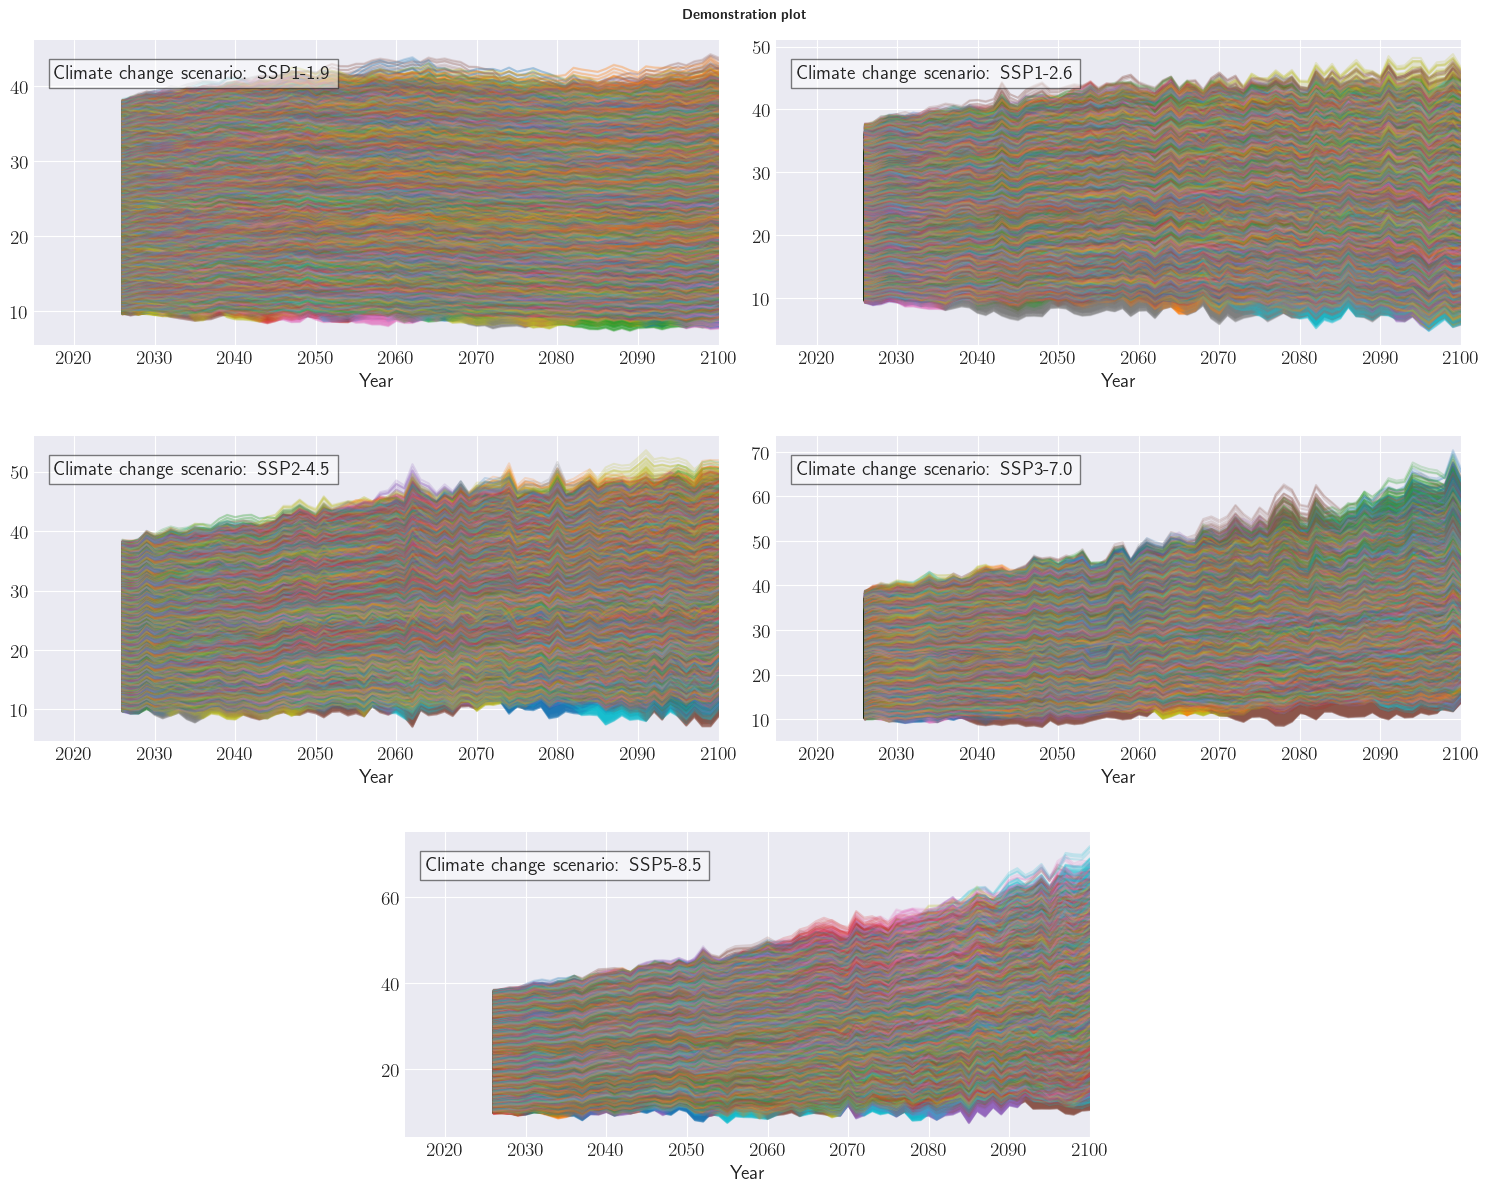

In [189]:
### Plot full data sampling
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['text.usetex'] = True
[nrows, ncols] = [2, 2]
fig = plt.figure(figsize=(15, 12))
fig.suptitle(r'\textbf{Demonstration plot}', y=0.99, fontsize=10)

gs = gridspec.GridSpec(nrows+1, ncols*2, figure=fig)
axes = [fig.add_subplot(gs[i, 2*j:2*j+2]) for i in range(nrows) for j in range(ncols)]
axes.append(fig.add_subplot(gs[2, 1:3]))

for i in range(len(list(climate_data_sample.keys()))):
    col = list(climate_data_sample.keys())[i]
    ax1 = axes[i]
    for j in range(data_sample_df.shape[0]):
            if data_sample_df["$z$"][j] == col:
                if "design" in data_sample_df.index[j]:
                    x_values = np.array([int(x.split('^{')[1].split('}$')[0]) for x in list(data_sample_df.keys()[6:])])
                    y_values = data_sample_df.iloc[j, 6:].values
                    # y_values = np.cumsum(y_values)
                    ax1.plot(x_values, y_values, alpha=0.2)

    ax1.set_xlabel(r'Year', fontsize=14)
    # ax1.set_ylabel(r'$\Sum y_{1}$: Total energy requirement (MWh)', fontsize=14)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.tick_params(axis='y', labelsize=14)
    ax1.set_xlim(min(data_future_df.index), max(data_future_df.index))
    ax1.text(0.03, 0.92, rf'Climate change scenario: {col}', transform=ax1.transAxes, fontsize=14,
             ha='left', va='top', bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout(rect=(0, 0, 1, 1))
plt.subplots_adjust(hspace=0.17, wspace=0.35)
# plt.savefig(os.path.join(result_dir, 'Full_data_sampling.png'), dpi=400)
plt.show()